# Env

In [ ]:
%%bash
conda create -n st python==3.7
conda activate st
conda install pandas
conda install seaborn
conda install scipy
conda install tqdm
conda install scikit-learn
conda install matplotlib

# Preprocess data

In [2]:
# load to NMFreg format

import pandas as pd
import numpy as np
from copy import deepcopy
import os

st_coords = pd.read_csv('../datasets/seqFISH+/Out_rect_locations.csv')
st_coords.columns = ['barcode','','','x','y']
st_coords = st_coords.drop('',axis=1)
st_counts_10000genes = pd.read_csv('../datasets/seqFISH+/Out_gene_expressions_10000genes.csv')
st_counts_10000genes = st_counts_10000genes.rename({'Unnamed: 0':'barcode'}, axis=1)
sc_counts = pd.read_csv('../datasets/seqFISH+/raw_somatosensory_sc_exp.txt',sep='\t')
sc_counts = sc_counts.set_index('cell_id')
sc_counts = sc_counts.T
sc_labels = pd.read_csv('../datasets/seqFISH+/somatosensory_sc_labels.txt',header=None)
sc_labels.columns = ['celltype']
celltype = list(set(sc_labels.celltype))
celltype_dict = dict(zip([x+1 for x in range(len(celltype))],celltype))
metacell_dict = dict(zip([str(x+1) for x in range(len(celltype))],celltype))
sc_labels['cluster'] = [celltype.index(x)+1 for x in sc_labels.celltype]
sc_labels['barcode'] = sc_counts.index

# Main

Populating the interactive namespace from numpy and matplotlib


/home/zhouj0d/software/anaconda3/envs/st/lib/python3.6/site-packages/ipykernel_launcher.py:457: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/zhouj0d/software/anaconda3/envs/st/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/zhouj0d/software/anaconda3/envs/st/lib/python3.6/site-packages/ipykernel_launcher.py:489: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


num mismatched: 226


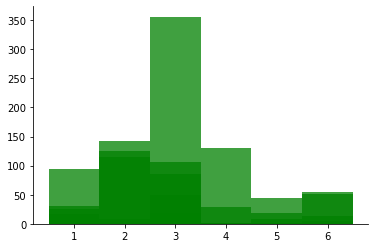

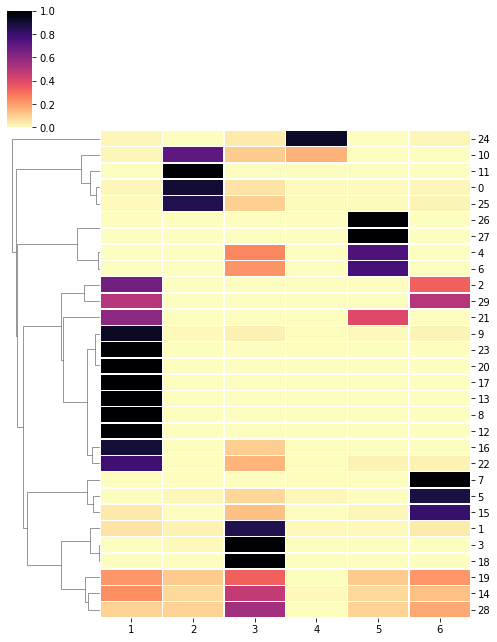

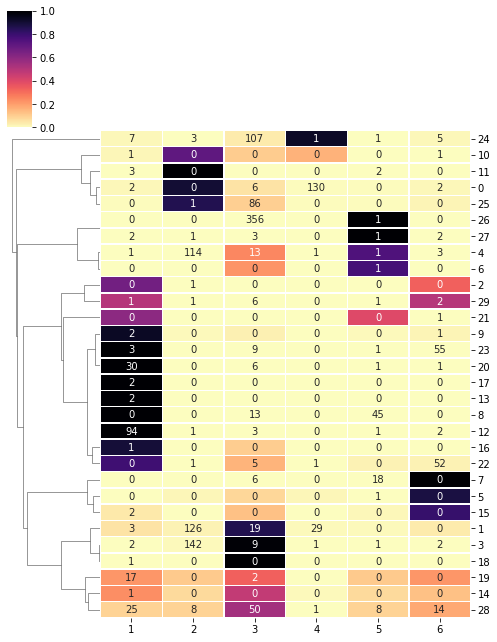

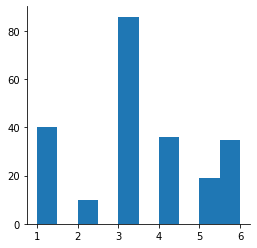

/home/zhouj0d/software/anaconda3/envs/st/lib/python3.6/site-packages/ipykernel_launcher.py:529: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/zhouj0d/software/anaconda3/envs/st/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


(1691, 7)


100%|██████████| 71/71 [00:00<00:00, 77.75it/s]
/home/zhouj0d/software/anaconda3/envs/st/lib/python3.6/site-packages/ipykernel_launcher.py:244: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


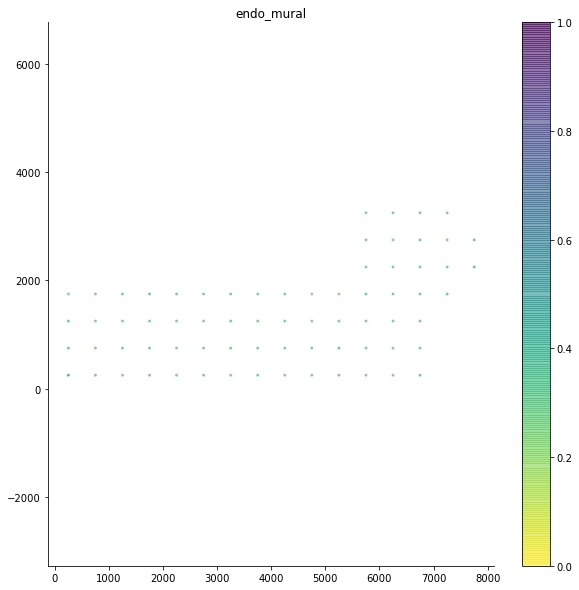

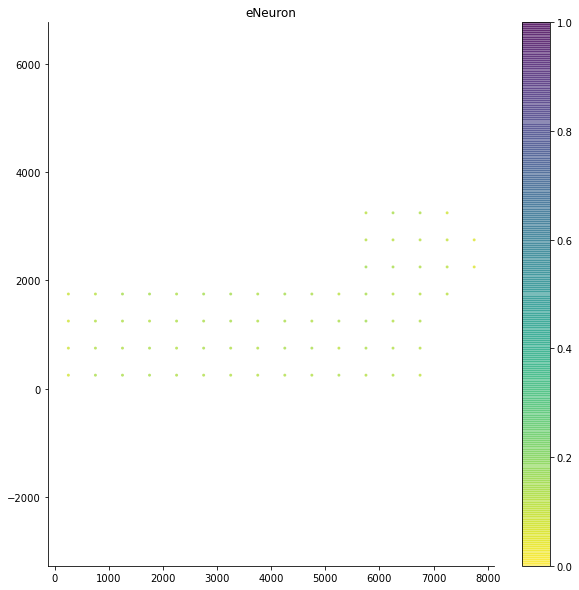

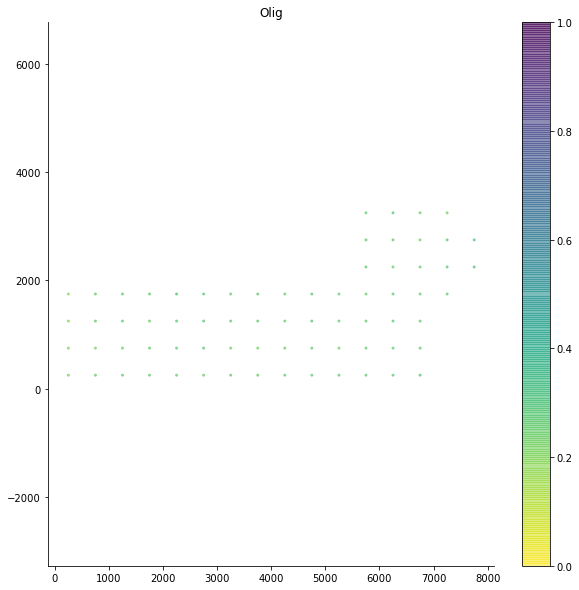

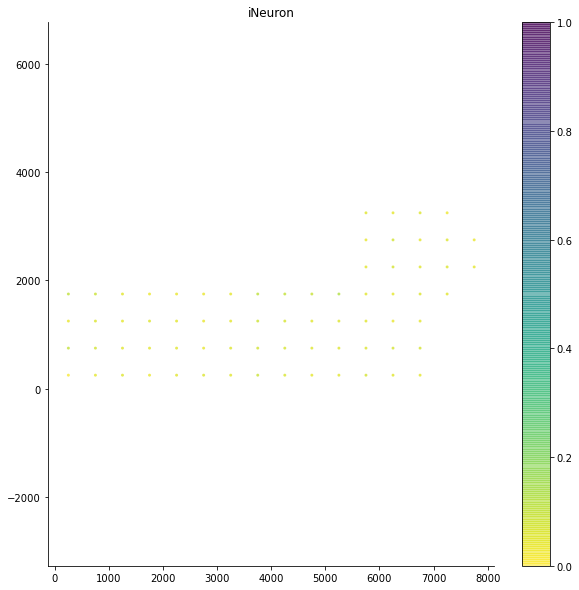

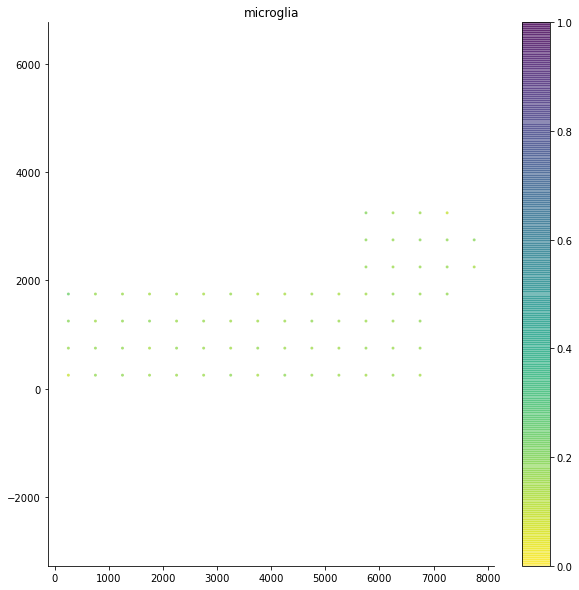

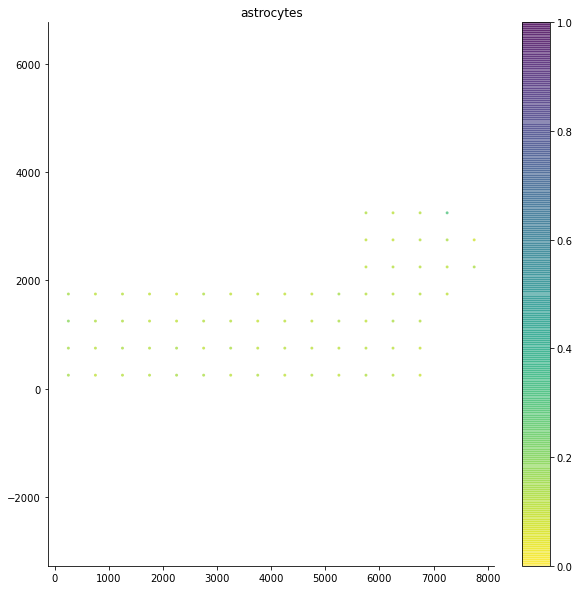

output file saved
10.851667642593384


In [5]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
import seaborn as sns
import scipy.stats
import scipy.optimize
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from matplotlib import colors
import matplotlib.patches as mpatches
import collections
import time
import matplotlib.pyplot as plt

%pylab inline

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

def plot_one_gene(gene):
    plt.figure(figsize(10, 10))
    pyplot.set_cmap('viridis_r')
    plt.scatter(coords['x'], coords['y'], c=counts[gene], s=2, alpha=0.6)
    plt.axis('equal')
    plt.title('{}'.format(gene))
    plt.colorbar()
    plt.show()
    
def deconv_factor_to_celltype(row, adict, K, num_atlas_clusters):
    nc = num_atlas_clusters
    tmp_list = [0]*nc
    for key in range(K):
        item = adict[key] - 1
        tmp_list[item] += row[key]**2
    return pd.Series(np.sqrt(tmp_list))


def NMFreg(counts, coords, size, metacell_dict, gene_intersection, 
           num_atlas_clusters, celltype_to_factor_dict, 
           celltype_dict, plot_size_dict):

    puckcounts = counts[['barcode'] + gene_intersection]
    puckcounts = puckcounts.set_index(counts['barcode'])
    puckcounts = puckcounts.drop('barcode', axis=1)

    cell_totalUMI = np.sum(puckcounts, axis = 1)
    puckcounts_cellnorm = np.divide(puckcounts, cell_totalUMI[:,None])
    puckcounts_scaled = StandardScaler(with_mean=False).fit_transform(puckcounts_cellnorm)

    XsT = puckcounts_scaled.T

    Hs_hat = []
    for b in tqdm(range(XsT.shape[1])):
        h_hat = scipy.optimize.nnls(WaT, XsT[:, b])[0]
        if b == 0:
            Hs_hat = h_hat
        else:
            Hs_hat = np.vstack((Hs_hat, h_hat))

    Hs = pd.DataFrame(Hs_hat)
    Hs['barcode'] = puckcounts.index.tolist()

    Hs_norm = StandardScaler(with_mean=False).fit_transform(Hs.drop('barcode', 
                                                                    axis=1))

    Hs_norm = pd.DataFrame(Hs_norm)
    Hs_norm['barcode'] = puckcounts.index.tolist()

    
    maxloc_s = Hs_norm.drop('barcode', axis=1).values.argmax(axis=1)
    barcode_clusters = pd.DataFrame()
    barcode_clusters['barcode'] = Hs_norm['barcode']
    barcode_clusters['max_factor'] = maxloc_s

    barcode_clusters['atlas_cluster'] = barcode_clusters['barcode']

    for c in range(1, num_atlas_clusters + 1):
        condition = np.isin(barcode_clusters['max_factor'], 
                            celltype_to_factor_dict[c])
        barcode_clusters['atlas_cluster'][condition] = c       
        
    bead_deconv_df = Hs_norm.apply(lambda x: deconv_factor_to_celltype(row=x, 
                                            adict=factor_to_celltype_dict,
                                            K=K,
                                            num_atlas_clusters=num_atlas_clusters), 
                                   axis = 1)
    bead_deconv_df.insert(0, 'barcode', Hs_norm['barcode'])
    bead_deconv_df.columns = ['barcode'] + (bead_deconv_df.columns[1:]+1).tolist()
    bead_deconv_df = pd.DataFrame(bead_deconv_df)
    bead_deconv_df = bead_deconv_df.rename(columns = celltype_dict)
    
    maxloc_ct = bead_deconv_df.drop('barcode', axis=1).values.argmax(axis=1)+1
    bead_maxct_df = pd.DataFrame()
    bead_maxct_df['barcode'] = bead_deconv_df['barcode']
    bead_maxct_df['max_cell_type'] = maxloc_ct
    
    return Hs, Hs_norm, puckcounts, bead_deconv_df, barcode_clusters, bead_maxct_df

def deconv_factor_to_celltype_sum(row, adict, K, num_atlas_clusters):
    nc = num_atlas_clusters
    tmp_list = [0]*nc
    for key in range(K):
        item = adict[key] - 1
        tmp_list[item] += row[key]
    return pd.Series(tmp_list)

def deconv_factor_to_celltype_l2(row, adict, K, num_atlas_clusters):
    nc = num_atlas_clusters
    tmp_list = [0]*nc
    for key in range(K):
        item = adict[key] - 1
        tmp_list[item] += row[key]**2
    return pd.Series(np.sqrt(tmp_list))

def deconv_factor_to_celltype_mean(row, adict, K, num_atlas_clusters):
    nc = num_atlas_clusters
    tmp_list = [0]*nc
    for key in range(K):
        item = adict[key] - 1
        tmp_list[item] += row[key]
    num_fact = list(collections.OrderedDict(sorted(collections.Counter(adict.values()).items())).values()) 
    mean_tmp_list = np.divide(tmp_list, num_fact)
    return pd.Series(mean_tmp_list)

def cell_deconv(collapse):
    if(collapse=='l2'):
        tmp_df = Ha_norm.drop('cellname', axis=1).apply(lambda x: deconv_factor_to_celltype_l2(row=x, 
                                                            adict=factor_to_celltype_dict,
                                                            K=K,
                                                            num_atlas_clusters=num_atlas_clusters), 
                                                        axis = 1)
    
    if(collapse=='sum'):
        tmp_df = Ha_norm.drop('cellname', axis=1).apply(lambda x: deconv_factor_to_celltype_sum(row=x, 
                                                            adict=factor_to_celltype_dict,
                                                            K=K,
                                                            num_atlas_clusters=num_atlas_clusters), 
                                                        axis = 1)
    
    if(collapse=='mean'):
        tmp_df = Ha_norm.drop('cellname', axis=1).apply(lambda x: deconv_factor_to_celltype_mean(row=x, 
                                                            adict=factor_to_celltype_dict,
                                                            K=K,
                                                            num_atlas_clusters=num_atlas_clusters), 
                                                        axis = 1)
    
    tmp_df.insert(0, 'cellname', Ha_norm['cellname'])
    tmp_df.columns = ['cellname'] + (tmp_df.columns[1:]+1).tolist()
    tmp_df = pd.DataFrame(tmp_df)
    tmp_df = tmp_df.rename(columns = celltype_dict)

    maxloc_cellt = tmp_df.drop('cellname', axis=1).values.argmax(axis=1)+1
    cell_maxct_df = pd.DataFrame()
    cell_maxct_df['cellname'] = tmp_df['cellname']
    cell_maxct_df['max_cell_type'] = maxloc_cellt

    mismatch_df = cell_clusters[np.array(cell_maxct_df['max_cell_type']) != np.array(cell_clusters['cluster'])]
    print('num mismatched: {}'.format(cell_clusters[np.array(cell_maxct_df['max_cell_type']) != np.array(cell_clusters['cluster'])].shape[0]))

    plt.figure(figsize(4, 4))
    plt.hist(mismatch_df['cluster'])
    plt.show()

    return tmp_df, mismatch_df, cell_maxct_df

def plot_bar_cellt(cell_deconv_df_norm, cell_maxct_df, metacell_dict):
    for key, value in metacell_dict.items():
        ct_df = cell_deconv_df_norm[cell_maxct_df['max_cell_type']==int(key)]
        plt.figure(figsize(4, 4))
        plt.bar(x=range(int(num_atlas_clusters)),
                height=np.sum(ct_df.drop(['cellname'], axis=1), axis=0),
                tick_label = list(metacell_dict.values()))
        plt.title(value)
        plt.xticks(rotation=90)
        plt.show()
        
def plot_hist_TF(cell_deconv_df_norm, cell_maxct_df, metacell_dict):
    posneg_dict = {}
    for key, value in metacell_dict.items():
        pos = cell_deconv_df_norm[value][cell_maxct_df['max_cell_type']==int(key)]
        neg = cell_deconv_df_norm[value][cell_maxct_df['max_cell_type']!=int(key)]
        posneg_dict[key] = [pos, neg]
        plt.figure(figsize(4, 4))
        plt.hist(pos, range=(0, 1), color='green', alpha=0.6, density=True)
        plt.hist(neg, range=(0, 1), color='red', alpha=0.6, density=True)
        plt.title(value)
        plt.xticks(rotation=90)
        plt.show()
    return posneg_dict

def func_thresh_certainty(bead_deconv_df_norm, keep_thresh_df, metacell_dict):
    for key, value in metacell_dict.items():
        bool_df = keep_thresh_df[int(key)-1]
        ct_indx = list(bead_deconv_df_norm.index[bool_df.index])
        res = np.multiply(bead_deconv_df_norm['maxval'].loc[ct_indx], bool_df)
        bead_deconv_df_norm['thresh_ct'].loc[ct_indx] = res
        
    return bead_deconv_df_norm

def maxval_func(row): 
    return row[ct_names][metacell_dict[str(row['max_cell_type'])]]

def plot_boolean(size, coords, bead_maxct_df,
                 plot_size_dict, metacell_dict):
    for key, value in metacell_dict.items():
        boolcol = (bead_maxct_df['max_cell_type']==int(key))
        sub_df = bead_maxct_df.copy()
        sub_df['bool'] = boolcol

        plt.figure(figsize(12, 12))
        plt.set_cmap('copper_r')
        plt.scatter(coords['x'], coords['y'], c=sub_df['bool'], 
                    s=plot_size_dict[size], alpha=0.6)
        plt.title('{} {}um'.format(value, size))
        plt.axis('equal')
        plt.show()
        
def plot_boolean_thresh(size, coords, bead_maxct_df, bead_deconv_df_norm,
                 plot_size_dict, metacell_dict):
    bool_col = bead_deconv_df_norm['thresh_ct']==0
    for key, value in metacell_dict.items():
        boolcol = bead_maxct_df['max_cell_type']==int(key)
        sub_df = bead_maxct_df.copy()
        sub_df['bool'] = boolcol
        bool_col_ct = np.multiply(bool_col, boolcol)

        plt.figure(figsize(12, 12))
        plt.set_cmap('copper_r')
        plt.scatter(coords['x'], coords['y'], c=sub_df['bool'], 
                    s=plot_size_dict[size], alpha=0.6)
        plt.scatter(coords[bool_col_ct]['x'], 
                    coords[bool_col_ct]['y'], 
                    c='lightgray', s=plot_size_dict[size], alpha=1)
        plt.title('{} {}um'.format(value, size))
        plt.axis('equal')
        plt.show()
        
def plot_ct_loadings(coords, size, puckcounts, bead_deconv_df, plot_size_dict):
    barcode_totalloading = np.sum(bead_deconv_df.drop('barcode', axis=1), 
                                  axis = 1)
    bead_deconv_df_norm = np.true_divide(bead_deconv_df.drop('barcode', axis=1), 
                                         barcode_totalloading[:,None])
    bead_deconv_df_norm['barcode'] = puckcounts.index.tolist()

    deconv_sub_df = bead_deconv_df_norm.drop('barcode', axis=1)

    for indx, col in deconv_sub_df.iteritems():
        plt.figure(figsize(10, 10))
        plt.set_cmap('viridis_r')
        plt.scatter(coords['x'], coords['y'], c=bead_deconv_df_norm[indx], 
                    s=plot_size_dict[size], alpha=0.6)
        plt.title('{}'.format(indx))
        plt.axis('equal')
        plt.colorbar()
        plt.clim(0,1)
        plt.show()
                                                                                            
    return bead_deconv_df_norm

def plot_allct(coords, size, bead_deconv_df_norm, 
               bead_maxct_df, plot_size_dict, num_atlas_clusters):
    bead_deconv_df_norm['max_cell_type'] = bead_maxct_df['max_cell_type']
    bead_deconv_df_norm['maxval'] = bead_deconv_df_norm.apply(maxval_func, 
                                                              axis=1)
    
    df_clust = pd.DataFrame(columns=['x','y','label'])
    df_clust['x'] = coords['x']
    df_clust['y'] = coords['y']
    df_clust['label'] = bead_deconv_df_norm['max_cell_type']

    facet = sns.lmplot(data=df_clust, x='x', y='y', hue='label', 
                       fit_reg=False, legend=False, legend_out=True,
                       palette = sns.color_palette("tab10", 
                                                   int(num_atlas_clusters)),
                       size = 10, scatter_kws={"s": 2*plot_size_dict[size]})
    #add a legend
    leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                             title="label", fancybox=True)
    #change colors of labels
    for i, text in enumerate(leg.get_texts()):
        plt.setp(text, color = sns.color_palette("tab10", 
                                                 int(num_atlas_clusters))[i])
    return df_clust, bead_deconv_df_norm

def plot_certainty(coords, size, bead_deconv_df_norm, plot_size_dict):
    plt.figure(figsize(12, 12))
    plt.set_cmap('Reds')
    plt.scatter(coords['x'], coords['y'], c=bead_deconv_df_norm['maxval'], 
                s=plot_size_dict[size], alpha=1)
    plt.title('Purity of most prevalent cell type per bead, {}um'.format(size))
    plt.axis('equal')
    plt.colorbar()
    plt.clim(0,1)
    plt.show()
    
def plot_certainty_thresh(coords, size, bead_deconv_df_norm, plot_size_dict):
    bool_col = bead_deconv_df_norm['thresh_ct']==0
    plt.figure(figsize(12, 12))
    plt.set_cmap('Reds')
    plt.scatter(coords['x'], coords['y'], c=bead_deconv_df_norm['maxval'], 
                s=plot_size_dict[size], alpha=1)
    plt.colorbar()
    plt.scatter(coords[bool_col]['x'], 
                    coords[bool_col]['y'], 
                    c='lightgray', s=plot_size_dict[size], alpha=1)
    plt.title('Purity of most prevalent cell type per bead, {}um'.format(size))
    expr = round(100*np.divide(coords[bead_deconv_df_norm['thresh_ct']!=0].shape[0],
                               coords.shape[0]), 2)
    plt.xlabel('Single celltype beads: {}%'.format(expr))
    plt.axis('equal')
    plt.clim(0,1)
    plt.show()
    
def plot_certainty_perct(coords, size, bead_deconv_df_norm, df_clust, 
                         plot_size_dict, metacell_dict):
    for key, value in metacell_dict.items():
        bool_col = df_clust['label']==int(key)
        ct_df = bead_deconv_df_norm[bool_col]
        plt.figure(figsize(12, 12))
        plt.set_cmap('Reds')
        plt.scatter(df_clust['x'], df_clust['y'], c='white', 
                    edgecolors='gray', linewidths=0.25, 
                    s=plot_size_dict[size], alpha=0.6)
        plt.scatter(coords[bool_col]['x'], coords[bool_col]['y'], 
                    c=ct_df['maxval'], s=plot_size_dict[size], alpha=0.9)
        plt.title('Purity of {} per bead, {}um'.format(value, size))
        plt.axis('equal')
        plt.colorbar()
        plt.clim(0,1)
        plt.show()
        
def plot_certainty_perct_thresh(coords, size, bead_deconv_df_norm, 
                                df_clust, bead_maxct_df, 
                                plot_size_dict, metacell_dict):
    keep_thresh_df = {}
    remove_thresh_df = {}
    bead_deconv_df_norm['max_cell_type'] = bead_maxct_df['max_cell_type']
    bead_deconv_df_norm['maxval'] = bead_deconv_df_norm.apply(maxval_func, 
                                                              axis=1)
    
    for key, value in metacell_dict.items():
        bool_col = (df_clust['label']==int(key)).tolist()
        ct_df = bead_deconv_df_norm[bool_col]
        ct_df['col'] = ct_df['maxval'].apply(lambda x: 0 if x <= thresh_certainty[int(key)-1] else x)
        keep_thresh_df[int(key)-1] = ct_df['maxval'] > thresh_certainty[int(key)-1]
        remove_thresh_df[int(key)-1] = ct_df['maxval'] <= thresh_certainty[int(key)-1]
        
        plt.figure(figsize(12, 12))
        plt.set_cmap('Reds')
        plt.scatter(df_clust['x'], df_clust['y'], c='white', 
                    edgecolors='gray', linewidths=0.25, 
                    s=plot_size_dict[size], alpha=0.6)
        plt.scatter(coords[bool_col]['x'], coords[bool_col]['y'], 
                    c=ct_df['col'], s=plot_size_dict[size], alpha=0.9)
        plt.colorbar();
        plt.scatter(coords[bool_col]['x'][ct_df['col']==0], 
                    coords[bool_col]['y'][ct_df['col']==0], 
                    c='gray', s=plot_size_dict[size], alpha=0.4)
        
        plt.title('Purity of {} per bead, {}um'.format(value, size))
        plt.axis('equal')
        plt.clim(0,1)
        plt.show()
        
    return keep_thresh_df, remove_thresh_df

def plot_pie(size, bead_deconv_df_norm, keep_thresh_df, remove_thresh_df,
             thresh_certainty, metacell_dict):
    for key, value in metacell_dict.items():
        thresh_cert = thresh_certainty[int(key)-1]
        total = np.sum(bead_deconv_df_norm['max_cell_type']==int(key))
        keep = np.sum(keep_thresh_df[int(key)-1])
        remove = np.sum(remove_thresh_df[int(key)-1])
        print(value)
        print('total: {}'.format(total))
        print('passed certainty check: {}'.format(keep))
        print('did not pass: {}'.format(remove))
        print('certainty thresh: {}'.format(round(thresh_cert, 4)))
        print('____________')
        plt.figure(figsize(6, 6))
        plt.pie(x=[keep, remove],
               labels = ['single celltype', 'mixed'],
               colors = ['xkcd:deep red', 'gray'],
               wedgeprops={'alpha':1},
               autopct =lambda x:'{:d}'.format(int(round(x*total/100))))
        title_str='{}um, {} purity threshold {}'.format(size, 
                                                        value, 
                                                        round(thresh_cert, 4))
        plt.title(title_str)
        plt.show()
        
def plot_bar_ct(bead_deconv_df_norm, df_clust, size, metacell_dict):
    for key, value in metacell_dict.items():
        ct_df = bead_deconv_df_norm[bead_deconv_df_norm['max_cell_type']==int(key)]
        plt.figure(figsize(4, 4))
        plt.bar(x=range(int(num_atlas_clusters)),
                height=np.sum(ct_df.drop(['barcode', 'max_cell_type', 
                'maxval', 'thresh_ct'], axis=1), axis=0),
                tick_label = list(metacell_dict.values()))
        plt.title(value)
        plt.xticks(rotation=90)
        plt.show()
        
def plot_allct_thresh(coords, size, bead_deconv_df_norm, bead_maxct_df,
                      plot_size_dict, metacell_dict):
    bool_col = bead_deconv_df_norm['thresh_ct']==0
    plt.figure(figsize(12, 12))
    for key, value in metacell_dict.items():
        boolcol = bead_maxct_df['max_cell_type']==int(key)
        #sub_df = bead_maxct_df.copy()
        #sub_df['bool'] = boolcol
        plt.scatter(coords[boolcol]['x'], coords[boolcol]['y'], 
                    #c=sns.color_palette("Paired", int(num_atlas_clusters))[int(key)-1], 
                    s=plot_size_dict[size], alpha=1)
        
        plt.scatter(coords[bool_col]['x'], 
                    coords[bool_col]['y'], 
                    c='lightgray', 
                    s=plot_size_dict[size], alpha=0.05)
    plt.title('All celltypes {}um'.format(size))
    plt.axis('equal')
    plt.show()
    return bead_deconv_df_norm

def get_df_clust(coords, bead_maxct_df):
    df_clust = pd.DataFrame(columns=['x','y','label'])
    df_clust['x'] = coords['x']
    df_clust['y'] = coords['y']
    df_clust['label'] = bead_maxct_df['max_cell_type']
    
    return df_clust

start = time.time()

counts = st_counts_10000genes

coords = st_coords

atlasdge = sc_counts

cell_clusters = sc_labels

output_file_name = 'seqFISH+_10000genes_NMFreg.csv'

####

atlas_genes = sc_counts.columns.tolist()

# need to have both the sample and the reference over a shared set of features
gene_intersection = list(set(atlas_genes) & set(counts.columns.drop('barcode')))
atlasdge = atlasdge[gene_intersection]

# preprocess the reference for NMF
cell_totalUMIa = np.sum(atlasdge, axis = 1)
atlasdge_cellnorm = np.divide(atlasdge, cell_totalUMIa[:,None])
atlasdge_scaled = StandardScaler(with_mean=False).fit_transform(atlasdge_cellnorm)

K = 30
random_state = 17
model = NMF(n_components=K, init='random', random_state = random_state)
Ha = model.fit_transform(atlasdge_scaled)
Wa = model.components_

Ha_norm = StandardScaler(with_mean=False).fit_transform(Ha)
Ha_norm = pd.DataFrame(Ha_norm)
Ha_norm['barcode'] = atlasdge.index.tolist()

maxloc = Ha_norm.drop('barcode', axis=1).values.argmax(axis=1)
cell_clusters['maxloc'] = maxloc
cell_clusters.head()

num_atlas_clusters = np.unique(cell_clusters['cluster']).size

factor_to_celltype_df = pd.DataFrame(0, index=range(1, num_atlas_clusters+1), 
                                     columns=range(K))
for k in range(K):
    n, bins, patches = plt.hist(cell_clusters['cluster'][cell_clusters['maxloc'] == k],
            range = (0.5, num_atlas_clusters+0.5), 
                                bins = int(num_atlas_clusters), 
                                facecolor='green', alpha=0.75)
    factor_to_celltype_df[k] = n.astype(int)
    
factor_to_celltype_df = factor_to_celltype_df.T

factor_total = np.sum(factor_to_celltype_df, axis = 1)
factor_to_celltype_df_norm = np.divide(factor_to_celltype_df, 
                                       factor_total[:,None])

cx = sns.clustermap(factor_to_celltype_df_norm, fmt = 'd',
                cmap="magma_r", linewidth=0.5, col_cluster = False,
                   figsize=(7, 9))

ax = sns.clustermap(factor_to_celltype_df_norm, fmt = 'd',
        cmap="magma_r", linewidth=0.5, col_cluster = False,
        annot = factor_to_celltype_df.loc[cx.dendrogram_row.reordered_ind],
        figsize=(7, 9))

maxloc_fc = factor_to_celltype_df.values.argmax(axis=1)
factor_to_celltype_dict = {factor : ctype + 1 for factor, ctype in enumerate(maxloc_fc)}

celltype_to_factor_dict = {}
for c in range(1, num_atlas_clusters + 1):
    celltype_to_factor_dict[c] = [k for k, v in factor_to_celltype_dict.items() if v == c]
    
WaT = Wa.T

Ha = pd.DataFrame(Ha)
Ha['cellname'] = atlasdge.index.tolist()

Ha_norm = StandardScaler(with_mean=False).fit_transform(Ha.drop('cellname', 
                                                                axis=1))

Ha_norm = pd.DataFrame(Ha_norm)
Ha_norm['cellname'] = atlasdge.index.tolist()

nonzero_beads = np.sum(counts[gene_intersection], axis=1)!=0
counts = counts[nonzero_beads]
coords = coords[list(nonzero_beads)]
coords.reset_index(drop=True, inplace=True)

co = collections.Counter(factor_to_celltype_dict.values())

cell_deconv_df, mismatch_dfl2, cell_maxct_df = cell_deconv(collapse='l2')

cell_totalloading = np.sum(cell_deconv_df.drop('cellname', axis=1), axis = 1)
cell_deconv_df_norm = np.true_divide(cell_deconv_df.drop('cellname', axis=1), 
                                     cell_totalloading[:,None])
cell_deconv_df_norm['cellname'] = cell_deconv_df['cellname']
print(cell_deconv_df_norm.shape)
cell_deconv_df_norm.head()

Hs, Hs_norm, puckcounts, bead_deconv_df, barcode_clusters, bead_maxct_df = NMFreg(counts=counts, 
                                        coords=coords, size=10, 
                                        metacell_dict=metacell_dict, 
                                        gene_intersection=gene_intersection, 
                                        num_atlas_clusters=num_atlas_clusters, 
                                        celltype_to_factor_dict=celltype_to_factor_dict, 
                                        celltype_dict=celltype_dict, 
                                        plot_size_dict={10:4})
bead_deconv_df_norm = plot_ct_loadings(coords=coords, size=10, 
                        puckcounts=puckcounts, 
                        bead_deconv_df=bead_deconv_df,
                        plot_size_dict={10:4})

bead_deconv_df_norm.head()

# save table
output_dir = '../seqFISH_10000_Result'
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)
bead_deconv_df_norm = bead_deconv_df_norm.set_index('barcode')
bead_deconv_df_norm.to_csv(f'{output_dir}/{output_file_name}',chunksize=5000)

print('output file saved')
end = time.time()
print(end - start)